In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy.linalg import inv 
import numpy.linalg as la

# Question 1

### Function for Lagrange Interpolation

In [4]:
def eval_lagrange(xeval,xint,yint,N):

    lj = np.ones(N+1)
    
    for count in range(N+1):
       for jj in range(N+1):
           if (jj != count):
              lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])

    yeval = 0.
    
    for jj in range(N+1):
       yeval = yeval + yint[jj]*lj[jj]
  
    return(yeval)

### Function for Hermite Interpolation

In [5]:
def eval_hermite(xeval,xint,yint,ypint,N):

    ''' Evaluate all Lagrange polynomials'''

    lj = np.ones(N+1)
    for count in range(N+1):
       for jj in range(N+1):
           if (jj != count):
              lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])

    ''' Construct the l_j'(x_j)'''
    lpj = np.zeros(N+1)
#    lpj2 = np.ones(N+1)
    for count in range(N+1):
       for jj in range(N+1):
           if (jj != count):
#              lpj2[count] = lpj2[count]*(xint[count] - xint[jj])
              lpj[count] = lpj[count]+ 1./(xint[count] - xint[jj])
              

    yeval = 0.
    
    for jj in range(N+1):
       Qj = (1.-2.*(xeval-xint[jj])*lpj[jj])*lj[jj]**2
       Rj = (xeval-xint[jj])*lj[jj]**2
#       if (jj == 0):
#         print(Qj)
         
#         print(Rj)
#         print(Qj)
#         print(xeval)
 #        return
       yeval = yeval + yint[jj]*Qj+ypint[jj]*Rj
       
    return(yeval)

### Functions for Natural Cubic Spline 

In [6]:
def create_natural_spline(yint,xint,N):

#    create the right  hand side for the linear system
    b = np.zeros(N+1)
#  vector values
    h = np.zeros(N+1)  
    for i in range(1,N):
       hi = xint[i]-xint[i-1]
       hip = xint[i+1] - xint[i]
       b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
       h[i-1] = hi
       h[i] = hip

#  create matrix so you can solve for the M values
# This is made by filling one row at a time 
    A = np.zeros((N+1,N+1))
    A[0][0] = 1.0
    for j in range(1,N):
       A[j][j-1] = h[j-1]/6
       A[j][j] = (h[j]+h[j-1])/3 
       A[j][j+1] = h[j]/6
    A[N][N] = 1

    Ainv = inv(A)
    
    M  = Ainv.dot(b)

#  Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    for j in range(N):
       C[j] = yint[j]/h[j]-h[j]*M[j]/6
       D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    return(M,C,D)

In [7]:
def eval_local_spline(xeval,xi,xip,Mi,Mip,C,D):
# Evaluates the local spline as defined in class
# xip = x_{i+1}; xi = x_i
# Mip = M_{i+1}; Mi = M_i

    hi = xip-xi
    yeval = (Mi*(xip-xeval)**3 +(xeval-xi)**3*Mip)/(6*hi) \
            + C*(xip-xeval) + D*(xeval-xi)
    return yeval 

In [8]:
def  eval_cubic_spline(xeval,Neval,xint,Nint,M,C,D):
    
    yeval = np.zeros(Neval+1)
    
    for j in range(Nint):
        '''find indices of xeval in interval (xint(jint),xint(jint+1))'''
        '''let ind denote the indices in the intervals'''
        atmp = xint[j]
        btmp= xint[j+1]
        
#   find indices of values of xeval in the interval
        ind= np.where((xeval >= atmp) & (xeval <= btmp))
        xloc = xeval[ind]

# evaluate the spline
        yloc = eval_local_spline(xloc,atmp,btmp,M[j],M[j+1],C[j],D[j])
#        print('yloc = ', yloc)
#   copy into yeval
        yeval[ind] = yloc

    return(yeval)

### Function for Clamped Cubic Spline

In [104]:
def create_clamped_spline(yint,ypint, xint,N):

#    create the right  hand side for the linear system
    b = np.zeros(N+1)
#  vector values
    h = np.zeros(N+1)
    for i in range(1,N):
       hi = xint[i]-xint[i-1]
       hip = xint[i+1] - xint[i]
       b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
       h[i-1] = hi
       h[i] = hip

    b[0] = -ypint[0] + (yint[1]-yint[0])/h[0]
    b[N] = -ypint[N] + (yint[N] - yint[N-1])/h[N-1]
#  create matrix so you can solve for the M values
# This is made by filling one row at a time 
    A = np.zeros((N+1,N+1))
    A[0][0] = h[0]/3
    A[0][1] = h[0]/6
    for j in range(1,N):
       A[j][j-1] = h[j-1]/6
       A[j][j] = (h[j]+h[j-1])/3 
       A[j][j+1] = h[j]/6
    A[N][N-1] = h[N-1]/6
    A[N][N] = h[N-1]/3

    Ainv = inv(A)
    
    M  = Ainv.dot(b)

#  Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    for j in range(N):
       C[j] = yint[j]/h[j]-h[j]*M[j]/6
       D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    return(M,C,D)

### Driver Function 

In [131]:
def driver(N):
        
    f = lambda x: 1./(1.+x**2)
    fp = lambda x: -2*x/(1.+x**2)**2

    ''' interval'''
    a = -5
    b = 5
   
    ''' create equispaced interpolation nodes'''
    xint = np.linspace(a,b,N+1)
    
    ''' create interpolation data'''
    yint = np.zeros(N+1)
    ypint = np.zeros(N+1)
    for jj in range(N+1):
        yint[jj] = f(xint[jj])
        ypint[jj] = fp(xint[jj])
    
    ''' create points for evaluating the Lagrange  interpolating polynomial'''
    Neval = 1000
    xeval = np.linspace(a,b,Neval+1)
    yeval_l= np.zeros(Neval+1)
    yevalH = np.zeros(Neval+1)
    for kk in range(Neval+1):
        yeval_l[kk] = eval_lagrange(xeval[kk],xint,yint,N)
        yevalH[kk] = eval_hermite(xeval[kk],xint,yint,ypint,N)

         
    ''' Spline '''
    
    (M,C,D) = create_natural_spline(yint,xint,N)
    
    yevalNC = eval_cubic_spline(xeval,Neval,xint,N,M,C,D)   
    
    ''' Clamped Spline'''
    (M,C,D) = create_clamped_spline(yint,ypint, xint,N)
    
    yevalCC = eval_cubic_spline(xeval,Neval,xint,N,M,C,D) 
        
    ''' create vector with exact values'''
    fex = np.zeros(Neval+1)
    for kk in range(Neval+1):
        fex[kk] = f(xeval[kk])

    '''Plotting'''
    
    plt.figure()    
    plt.plot(xeval,fex,'ro-', label = "true") #plot true function values
    plt.plot(xeval,yeval_l,'b.--',  label = f'lagrange, N ={N}') #plot lagrange
    plt.plot(xeval,yevalH,'g.--',label=f'Hermite, N ={N}') # plot hermite 
    plt.plot(xeval,yevalNC,'k.--',label=f'Natural Cubic Spline, N ={N}') #plot cubic spline
    plt.plot(xeval, yevalCC, 'c.--',label=f'Clamped Cubic Spline, N = {N}')#plot clamped cubic spline
    
    if N >= 15:
        plt.semilogy()
    plt.legend()

    plt.figure() 
    err_l = abs(yeval_l-fex) # lagrange error
    errH = abs(yevalH-fex)   # hermite error
    errNC = abs(yevalNC-fex) # cubic error
    errCC = abs(yevalCC-fex) # clamped error

    plt.semilogy(xeval,err_l,'b.--',label=f'Lagrange Error, N ={N}') # plot lagrange error
    plt.semilogy(xeval,errH,'g.--',label=f'Hermite Error, N ={N}') # plot hermite error
    plt.semilogy(xeval,errNC,'k.--',label=f'Natural Cubic Spline Error, N ={N}') #plot cubic error
    plt.semilogy(xeval,errCC,'c.--',label=f'Clamped Cubic Spline Error, N={N}') #plot clamped error
    plt.legend()
    plt.show()

    return 

### Plots with N = 5, 10, 15, 20

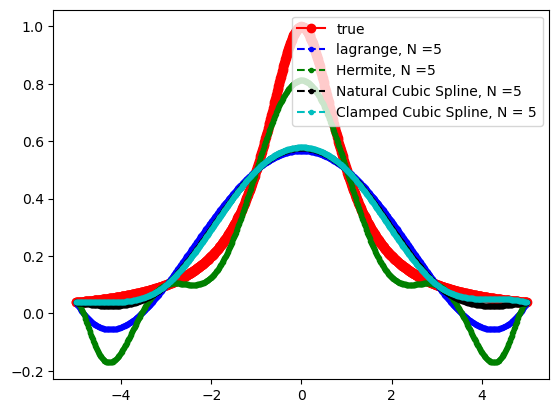

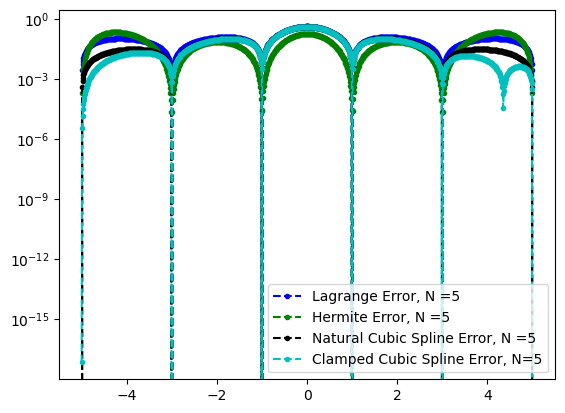

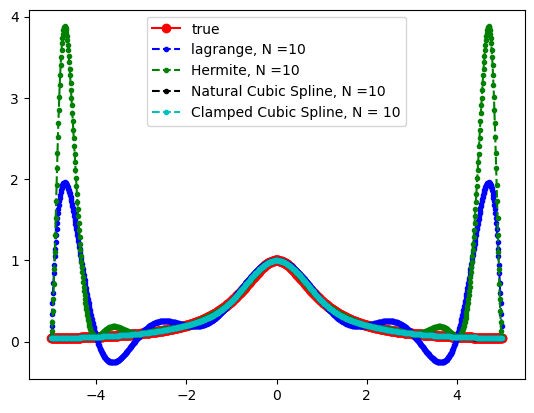

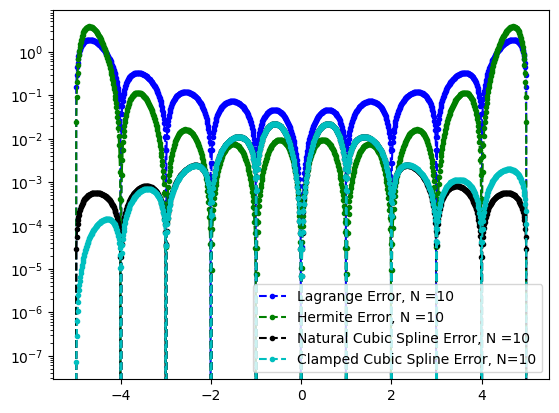

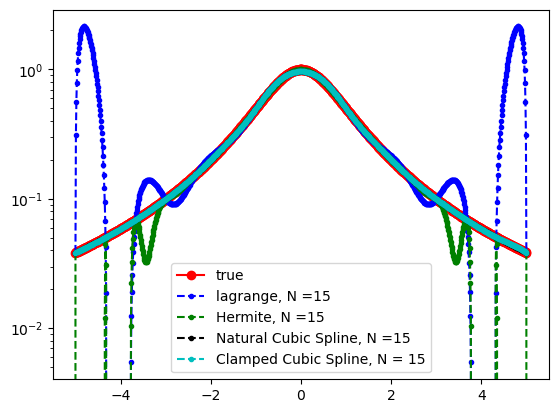

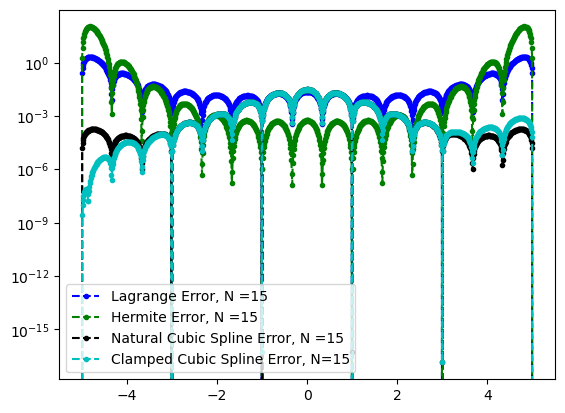

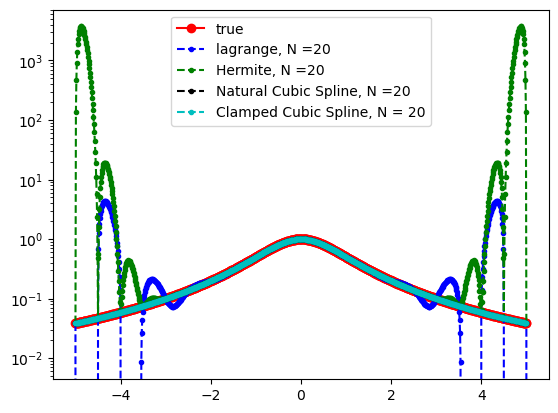

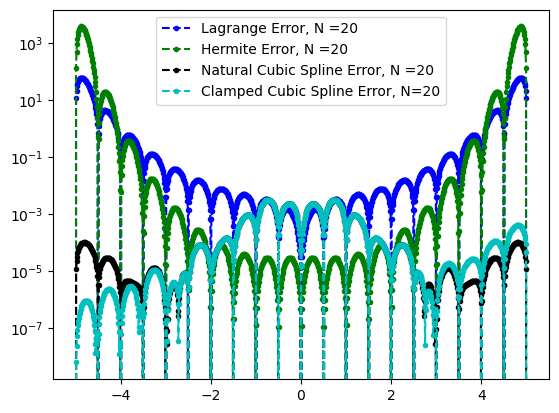

(None, None, None, None)

In [132]:
driver(5),driver(10),driver(15),driver(20)

For all values of N, the Hermite method of interpolation performs the best at the middle of the range, the peak of the true function. This difference is more significant with the higher values of N. On the right endpoint, the natural cubic spline performs best for all values of N, though only slightly better than the clamped version, though both cubic splines perform considerably better than the Lagrange and Hermite interpolations at both left and right endpoints. The clamped cubic spline performs the best at the left endpoint, and the difference between it and its natural counterpart is a little greater than at the right endpoint. Thus, it seems that overall the clamped cubic spline performs the best for higher values of N as the errors at the endpoints for the Lagrange and Hermite is massive compared to the cubic splines. At the low end values, all methods perform relatively the same, with splines best at the endpoints and hermite best in the center. 

# Question 2

In [158]:
def driver_cheby(N):

    f = lambda x: 1./(1.+x**2)
    fp = lambda x: -2*x/(1.+x**2)**2

    ''' interval'''
    a = -5
    b = 5
   
    xint = np.zeros(N)
    ''' create equispaced interpolation nodes'''
    for j in range(1,N+1):
        xint[j-1] = 5*np.cos(((2*j - 1)*np.pi)/(2*N))
    xint = np.flip(xint)
    ''' create interpolation data'''
    yint = np.zeros(N+1)
    ypint = np.zeros(N+1)
    for jj in range(N):
        yint[jj] = f(xint[jj])
        ypint[jj] = fp(xint[jj])
    
    ''' create points for evaluating the Lagrange  interpolating polynomial'''
    Neval = 1000
    xeval = np.linspace(a,b,Neval+1)
    yeval_l= np.zeros(Neval+1)
    yevalH = np.zeros(Neval+1)
    for kk in range(Neval+1):
        yeval_l[kk] = eval_lagrange(xeval[kk],xint,yint,N-1)
        yevalH[kk] = eval_hermite(xeval[kk],xint,yint,ypint,N-1)

         
    ''' Spline '''
    
    (M,C,D) = create_natural_spline(yint,xint,N-1)
    
    yevalNC = eval_cubic_spline(xeval,Neval,xint,N-1,M,C,D)   
    
    ''' Clamped Spline'''
    (M,C,D) = create_clamped_spline(yint,ypint, xint,N-1)
    
    yevalCC = eval_cubic_spline(xeval,Neval,xint,N-1,M,C,D) 
        
    ''' create vector with exact values'''
    fex = np.zeros(Neval+1)
    for kk in range(Neval+1):
        fex[kk] = f(xeval[kk])

    '''Plotting'''
    
    plt.figure()    
    plt.plot(xeval,fex,'ro-', label = "true") #plot true function values
    plt.plot(xeval,yeval_l,'b.--',  label = f'lagrange, N ={N}') #plot lagrange
    plt.plot(xeval,yevalH,'g.--',label=f'Hermite, N ={N}') # plot hermite 
    plt.plot(xeval,yevalNC,'k.--',label=f'Natural Cubic Spline, N ={N}') #plot cubic spline
    plt.plot(xeval, yevalCC, 'c.--',label=f'Clamped Cubic Spline, N = {N}')#plot clamped cubic spline
    
    if N >= 15:
        plt.semilogy()
    plt.legend()

    plt.figure() 
    err_l = abs(yeval_l-fex) # lagrange error
    errH = abs(yevalH-fex)   # hermite error
    errNC = abs(yevalNC-fex) # cubic error
    errCC = abs(yevalCC-fex) # clamped error

    plt.semilogy(xeval,err_l,'b.--',label=f'Lagrange Error, N ={N}') # plot lagrange error
    plt.semilogy(xeval,errH,'g.--',label=f'Hermite Error, N ={N}') # plot hermite error
    plt.semilogy(xeval,errNC,'k.--',label=f'Natural Cubic Spline Error, N ={N}') #plot cubic error
    plt.semilogy(xeval,errCC,'c.--',label=f'Clamped Cubic Spline Error, N={N}') #plot clamped error
    plt.legend()
    plt.show()

    return

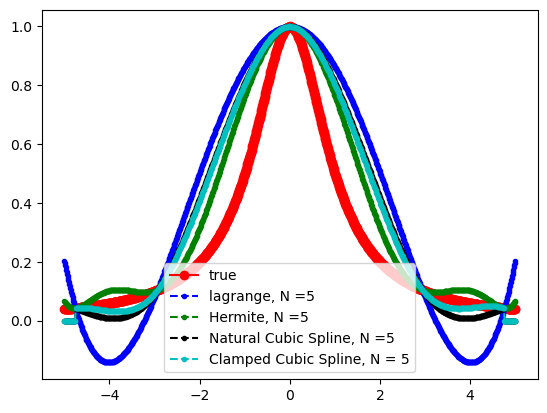

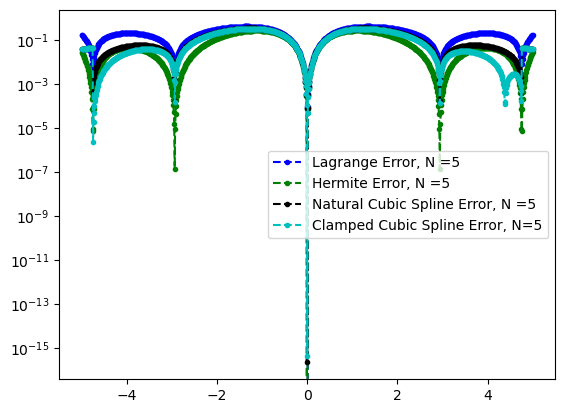

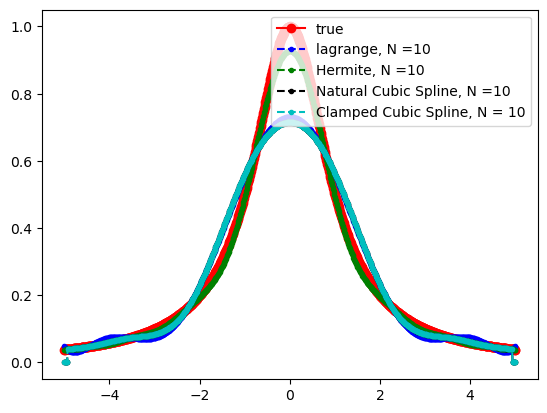

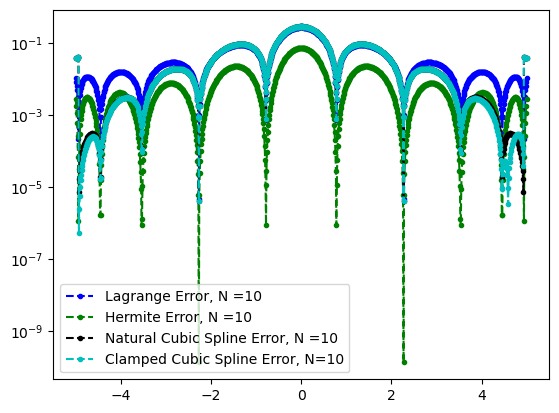

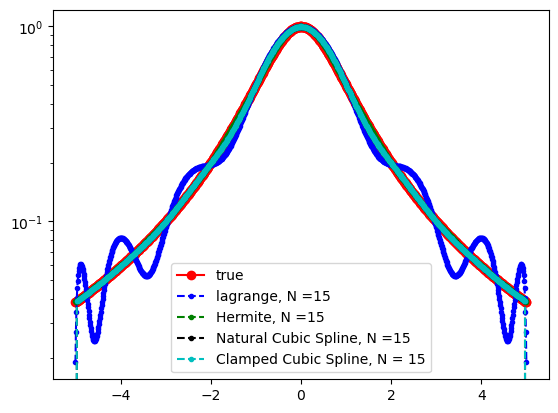

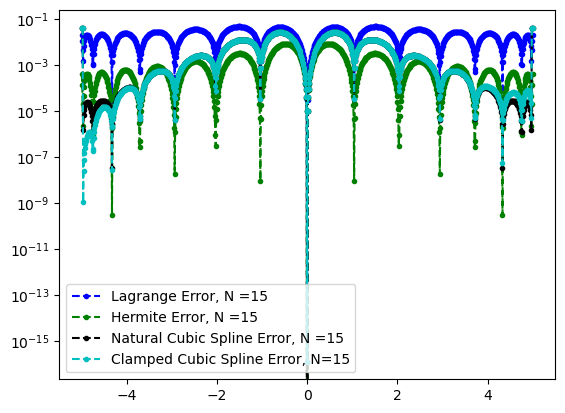

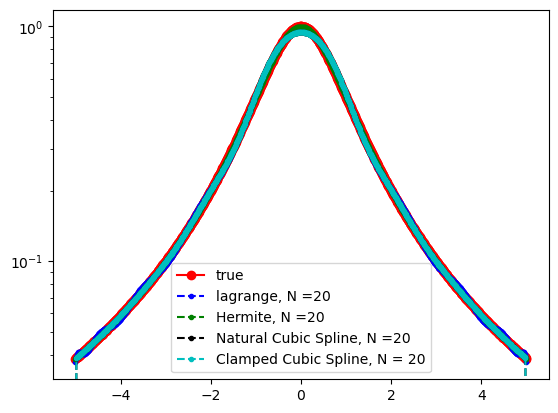

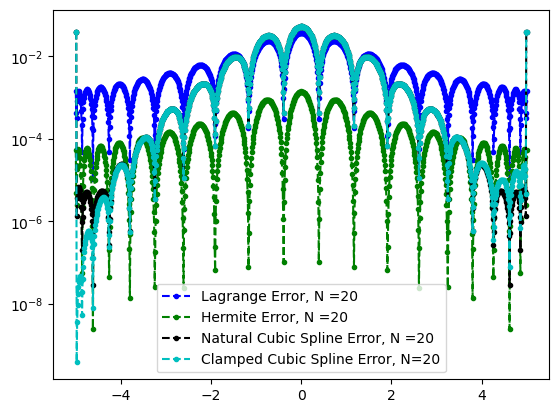

(None, None, None, None)

In [160]:
driver_cheby(5),driver_cheby(10),driver_cheby(15),driver_cheby(20)

All methods are now considerably more accurate at the endpoints, though not as much change for the cubic splines as those were already pretty accurate.